In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
sys.path

NameError: name 'sys' is not defined

In [2]:
import os
import sys
import pickle as pkl
from argparse import ArgumentParser
from copy import deepcopy
from os.path import join as oj
import numpy as np
import torch
from torch import nn
import torch.utils.data
from torch import optim
import pickle
from torch.utils.data import DataLoader, TensorDataset
sys.path.insert(0, "../1D CNN")
import data_fns
import utils
import pandas as pd
import models
# import cmcrameri.cm as cmc
import torchvision
from matplotlib import pyplot as plt
import matplotlib as mpl
# mpl.rc('image', cmap='cmc.batlow')
cuda = torch.cuda.is_available()
import csv
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
from sklearn import metrics
import configparser
config = configparser.ConfigParser()
config.read("../config.ini")

Using device: cpu


[]

In [8]:
file_path = "TS_freq_array_0208_new.csv"
model_path = "C:\\Users\\aethe\\1D CNN"

y_labels = []
x_TS = []
fish_num = []
final_labels = []
# Read the CSV file line by line
with open(file_path, 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    
    next(csv_reader)
    
    # Extract the first column and construct rows as arrays
    for row in csv_reader:
        fish_num.append(row[0])
        y_labels.append(row[1])
        x_TS.append(row[2:])
        final_labels.append([row[-2],row[-1]])


x_TS = np.array(x_TS, dtype = float)

print(x_TS.shape) # (32954, 249)

means = np.mean(x_TS, axis=0)
std_devs = np.std(x_TS, axis=0)
x_TS = (x_TS - means) / std_devs  # Standardizing data


# Contruct data and labels
data = x_TS[:, None]
labels = np.array(y_labels, dtype=int)
final_labels = np.array(final_labels, dtype=int)

fish_num_to_index = {fish_num: index for index, fish_num in enumerate(np.unique(np.array(fish_num)))}

# Use the mapping to convert the fish_num to indices
fish_ind = np.array([fish_num_to_index[num] for num in fish_num])


train_idxs_by_fish, val_idxs_by_fish, test_idxs_by_fish = data_fns.get_split(len(np.unique(fish_ind)), seed=23)

def construct_data_index_by_fish_idxs(idxs_split_by_fish, fish_ind):
    indx = np.array([], dtype=int)  # Ensure the array is of integer type
    for split_fish_ind in idxs_split_by_fish:
        # Ensure split_fish_ind is an integer before using it as an index
        split_fish_ind = int(split_fish_ind)
        indx_current_fish = np.where(fish_ind == split_fish_ind)[0]
        indx = np.append(indx, indx_current_fish)

    return indx



# Indices that we use in the model
train_idxs = construct_data_index_by_fish_idxs(train_idxs_by_fish, fish_ind)
val_idxs = construct_data_index_by_fish_idxs(val_idxs_by_fish, fish_ind)
test_idxs = construct_data_index_by_fish_idxs(test_idxs_by_fish, fish_ind)

def balance_classes_by_indices(indices, labels, n_samples_per_class):
    unique_classes = np.unique(labels[indices])
    balanced_indices = np.array([], dtype=int)

    for cls in unique_classes:
        class_indices = indices[labels[indices] == cls]
        if len(class_indices) > n_samples_per_class:
            class_indices = np.random.choice(class_indices, n_samples_per_class, replace=False)
        else:
            class_indices = np.random.choice(class_indices, n_samples_per_class, replace=True)
        balanced_indices = np.append(balanced_indices, class_indices)

    np.random.shuffle(balanced_indices)  # Shuffle to mix classes
    return balanced_indices

# Apply balancing to each split
balanced_train_idxs = balance_classes_by_indices(train_idxs, labels, n_samples_per_class=10029)
balanced_val_idxs = balance_classes_by_indices(val_idxs, labels, n_samples_per_class=1000)
balanced_test_idxs = balance_classes_by_indices(test_idxs, labels, n_samples_per_class=2000)

(32954, 251)


In [9]:
fnames = sorted([oj(model_path, fname) for fname in os.listdir(model_path) if "pkl" in fname]) 
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in (fnames)] 
results_all = pd.concat(results_list, axis=1).T.infer_objects()


In [13]:

# results_all = results_all[results_all.exp_name == "FinalModels"]

In [10]:
used_idxs= balanced_test_idxs


In [7]:
model_idx =  results_all.test_auc.argmax()

model = models.FGANet(num_input= data.shape[2],
                      num_in_channels=1, 
                      num_output = 2, 
      
                      conv_channels = 16,
                      stride = 1).to(device)

model.load_state_dict(torch.load(oj(model_path,results_all.iloc[model_idx].filename+".pt")))
model = model.to(device)
model.eval();

In [11]:
pred_y = model.forward(torch.Tensor(data[used_idxs])).detach().cpu().numpy()
true_y = final_labels[used_idxs]

# max activation

In [46]:

feature_dataset = TensorDataset(
    *[torch.Tensor(input) for input in [data[used_idxs], final_labels[used_idxs]]]
) 
true_y_feature = final_labels[used_idxs]
features_output= np.zeros(((len(used_idxs),3648)))
feature_loader = DataLoader(feature_dataset, batch_size=128, shuffle=False)
for batch_idx, (
        data_cur,
        label_cur,
    ) in enumerate(feature_loader):
    features_output[batch_idx*128:batch_idx*128+data_cur.shape[0]] = model.features.forward(data_cur).detach().cpu().numpy()

num_channels = 64

features_output = np.reshape(features_output, (len(used_idxs),num_channels, -1 ))
num_outputs = features_output.shape[-1]
features_output = np.swapaxes(features_output, 0,1)

In [47]:
num_outputs

57

In [48]:
num_dataset = features_output.shape[1]


In [49]:
num_samples_all=100
test_out = np.empty((num_channels, num_samples_all,16))

padding =5 
for j in range(num_channels):
    
    test_features = np.copy(features_output[j])[:,padding:-padding] 
    max_idx = test_features.reshape(-1).argsort()[-num_samples_all:]

    maxpos_vect = np.column_stack(np.unravel_index(max_idx, ( num_dataset, 57-2*padding)))
#     if j ==0:
#         print(maxpos_vect+padding)
    for i in range(num_samples_all):
        neuron_pos = maxpos_vect[i,1]+padding
        test_out[j,i] =data[used_idxs,0][maxpos_vect[i,0]][(neuron_pos)* 4:(neuron_pos)* 4+16]



In [50]:
import random

def generate_color_codes(num_colors):
    colors = set()
    while len(colors) < num_colors:
        color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
        colors.add(color)
    return list(colors)

color_codes = generate_color_codes(32)
print(color_codes)

['#3057d3', '#4f7470', '#da4ef8', '#5e4bab', '#2014aa', '#a4c7bc', '#61cbfa', '#bc123b', '#36f4e9', '#597d9c', '#ab2871', '#fb3365', '#f0861e', '#009a74', '#2abb52', '#6262f0', '#5a1a91', '#66ed3b', '#71127d', '#2a1332', '#6829b7', '#e9074c', '#7e1aec', '#c337f4', '#6acef3', '#c4abad', '#f0e7d9', '#f9e8f9', '#220539', '#9c960b', '#42a463', '#247b70']


C:\Users\aethe\AppData\Local\Temp\ipykernel_6236\901048916.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('Dark2')


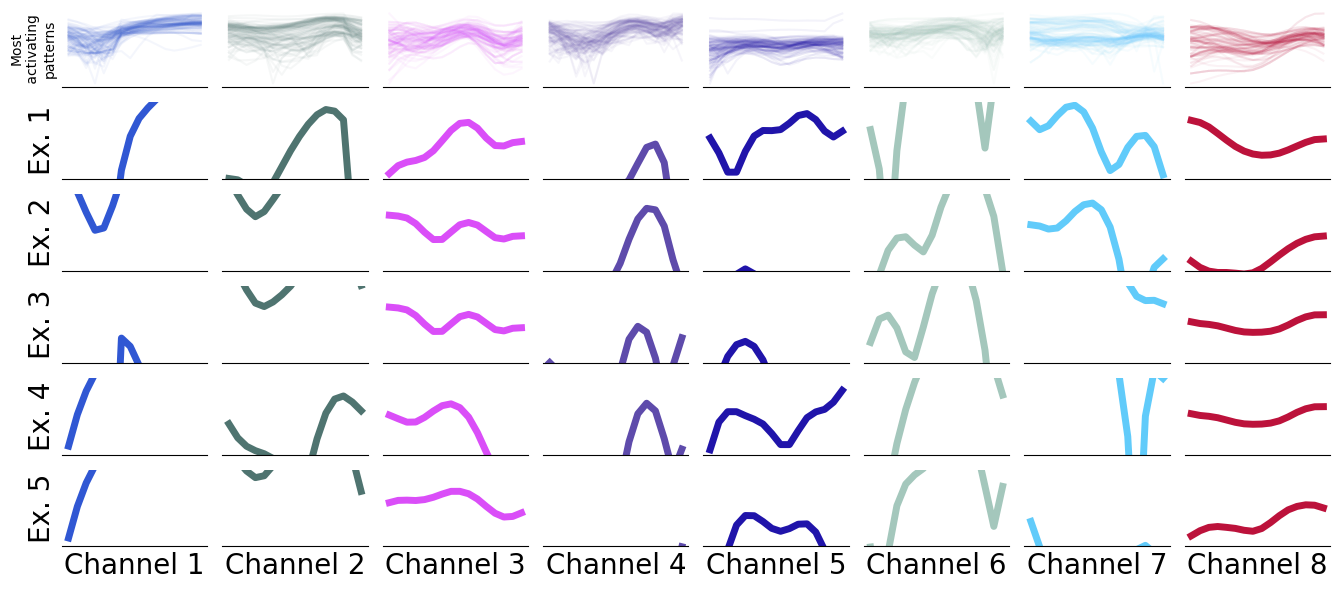

In [51]:
# colors = ['#5a05fa', '#320594', '#11ccb9', '#018786', '#cb3461', '#792039', '#f5660a', '#8e3d0b',
#           '#DFFF00','#FFBF00','#FF7F50','#DE3163', '#9FE2BF','#40E0D0','#6495ED','#CCCCFF',]
colors = color_codes
np.random.seed(0)
num_samples=5
cmap = mpl.cm.get_cmap('Dark2')


fig, axes = plt.subplots(ncols = 8, 
                         nrows = num_samples+1, 
                         figsize = ((8+1)*1.5, 
                                    (num_samples+1)*1))

for i in range(8):
    axes[0,i].plot(test_out[i].T, c= colors[i], alpha = .05)
    axes[0,0].set_ylabel("Most\n activating \npatterns", fontsize = 10, rotation = 90)
    axes[-1,i].set_xlabel("Channel {}".format(i+1), fontsize = 20)
#     axes[0,i].set_xlabel("Channel # {}".format(i), )
#     axes[-2,i].xaxis.labelpad = 50
    my_idxs =-np.random.choice(num_samples_all,size=num_samples)

    axes[0,i].set_yticks([]);
    axes[0,i].set_xticks([]);        
    axes[0,i].spines.right.set_visible(False)
    axes[0,i].spines.top.set_visible(False)
        
    axes[0,i].spines.left.set_visible(False)
    for j in range(1,num_samples+1):
        axes[j,0].set_ylabel("Ex. {}".format(j), fontsize = 20,)

#         axes[j,0].set_ylabel("Ex. # {}".format(j-1))

        axes[j,i].plot(test_out[i,my_idxs[j-1]], 
                       linewidth =5,  
                       c=  colors[i])
        axes[j,i].set_yticks([]);
        axes[j,0].set_yticks([]);
        axes[j,i].spines.right.set_visible(False)
        axes[j,i].spines.top.set_visible(False)
        
        axes[j,i].spines.left.set_visible(False)
   
        

        axes[j,i].set_xticks([]);
        axes[j,i].set_ylim([0,1.05], );

    

axes[0,0].set_yticks([]);

plt.tight_layout()


    


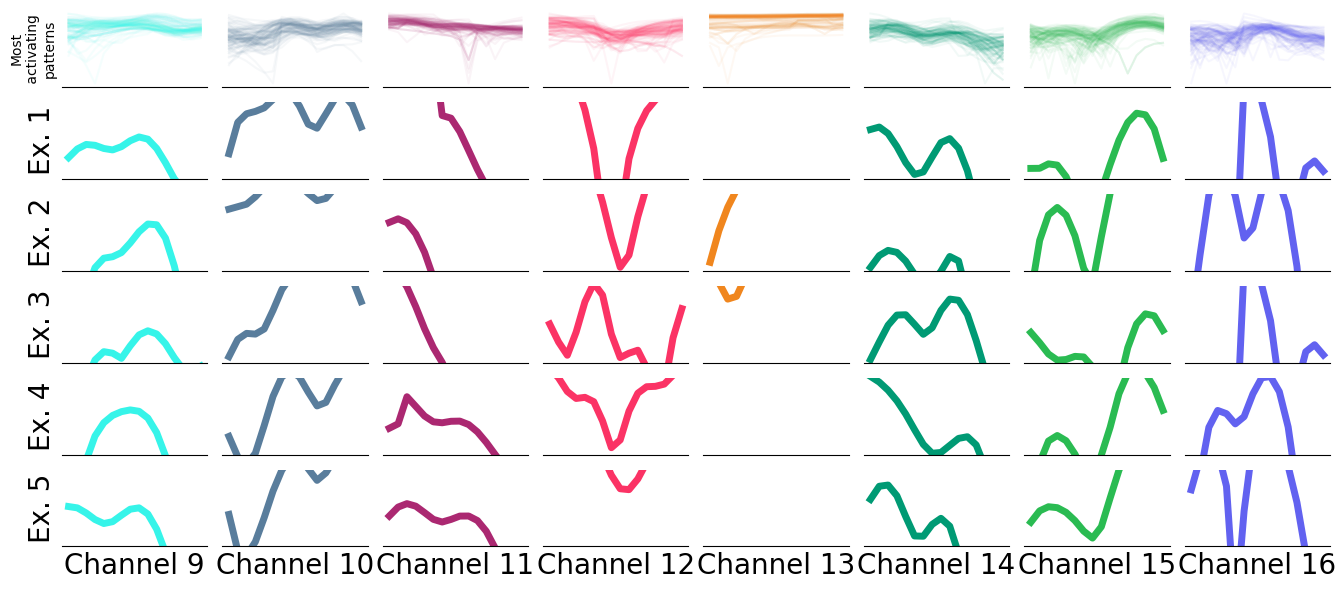

In [52]:

fig, axes = plt.subplots(ncols = 8, 
                         nrows = num_samples+1, 
                         figsize = ((8+1)*1.5, 
                                    (num_samples+1)*1))

for i in range(8):
    axes[0,i].plot(test_out[i+8].T, c= colors[i+8], alpha = .05)
    axes[0,0].set_ylabel("Most\n activating \npatterns", fontsize = 10, rotation = 90)
    axes[-1,i].set_xlabel("Channel {}".format(i+9), fontsize = 20)
#     axes[0,i].set_xlabel("Channel # {}".format(i), )
#     axes[-2,i].xaxis.labelpad = 50
    my_idxs =-np.random.choice(num_samples_all,size=num_samples)

    axes[0,i].set_yticks([]);
    axes[0,i].set_xticks([]);        
    axes[0,i].spines.right.set_visible(False)
    axes[0,i].spines.top.set_visible(False)
        
    axes[0,i].spines.left.set_visible(False)
    for j in range(1,num_samples+1):
        axes[j,0].set_ylabel("Ex. {}".format(j), fontsize = 20,)

#         axes[j,0].set_ylabel("Ex. # {}".format(j-1))

        axes[j,i].plot(test_out[i+8,my_idxs[j-1]], 
                       linewidth =5,  
                       c=  colors[i+8])
        axes[j,i].set_yticks([]);
        axes[j,0].set_yticks([]);
        axes[j,i].spines.right.set_visible(False)
        axes[j,i].spines.top.set_visible(False)
        
        axes[j,i].spines.left.set_visible(False)
   
        

        axes[j,i].set_xticks([]);
        axes[j,i].set_ylim([0,1.05], );

    

axes[0,0].set_yticks([]);

plt.tight_layout()

In [ ]:
# zoomed in feature

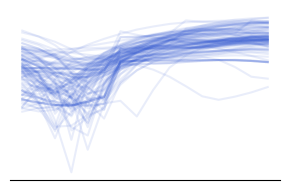

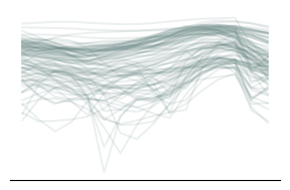

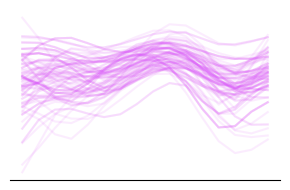

In [53]:




# gs1 = gridspec.GridSpec(4, 4)
# gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 
channel_list = [0,1,2]
for i in channel_list:
    fig, axes = plt.subplots(ncols = 1, 
                         nrows = 1, 
                         figsize = (3,2))
    axes.plot(test_out[i].T, c= colors[i], alpha = .1)

#     maxpos_vect = np.column_stack(np.unravel_index(max_idx, ( num_dataset, 209)))
    axes.set_yticks([]);
    axes.set_xticks([]);        
    axes.spines.right.set_visible(False)
    axes.spines.top.set_visible(False)
        
    axes.spines.left.set_visible(False)

        

#         axes[j,i].set_xticks([]);
    axes.set_yticks([]);
#         axes[j,i].set_ylim([0,1.05], );
    plt.tight_layout()

    



# new grad

In [79]:
# x_values = np.arange(45,170.5,0.5)
# elements_to_remove = [90.0, 90.5]
# x_values = x_values[~np.isin(x_values, elements_to_remove)]
# print(x_values)

# b = np.asarray(x_values)
b = np.asarray([45, 70,90,110,130,150,170.5])
a = (b).astype(np.int32)
# plt.xticks(ticks = a,labels = b, fontsize = 20);

In [55]:
x_values.shape

(249,)

In [56]:
W = model.classifier[0].weight.detach().cpu().numpy()
W.shape

(2, 3648)

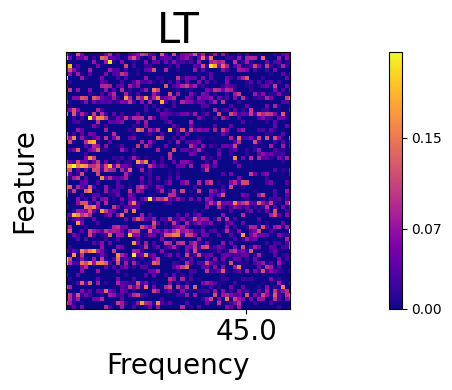

In [80]:
W = model.classifier[0].weight.detach().cpu().numpy()
W = W.reshape((2, 64, -1))
# highest_val = np.percentile(W, 99.9)
lowest_val = 0
# for functional_group in range(17):


W_fun = W[0]
W_fun = np.maximum(0, W_fun)
highest_val = np.percentile(W_fun, 99.9)
fig, ax = plt.subplots(figsize = (20,4))



plt.imshow(W_fun, vmin = lowest_val, vmax = highest_val, cmap =plt.get_cmap('plasma'))

plt.xticks(ticks = a,labels = b, fontsize = 20);
plt.yticks([]);
ax.set_xlim(0,56)
ax.set_xlabel("Frequency", fontsize =20,)

ax.set_ylabel("Feature", fontsize =20,rotation = 90, labelpad=20)
plt.title("LT", fontsize = 30);
plt.colorbar(ticks = [0, 0.07,.15])
plt.tight_layout()

# break


In [42]:
model.classifier[0].weight.detach().cpu().numpy().shape


(2, 3648)

In [77]:
W_fun.shape

(64, 57)

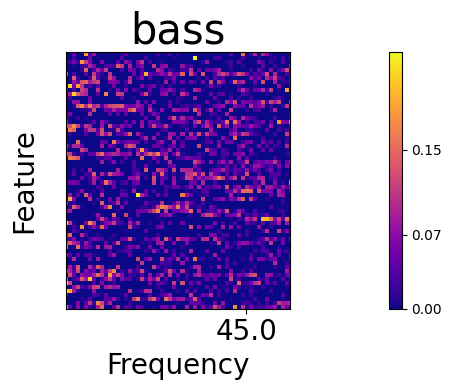

In [81]:
W_fun = W[1]
W_fun = np.maximum(0, W_fun)
highest_val = np.percentile(W_fun, 99.9)
fig, ax = plt.subplots(figsize = (20,4))



plt.imshow(W_fun, vmin = lowest_val, vmax = highest_val, cmap =plt.get_cmap('plasma'))

plt.xticks(ticks = a,labels = b, fontsize = 20);
plt.yticks([]);
ax.set_xlim(0,56)
ax.set_xlabel("Frequency", fontsize =20,)

ax.set_ylabel("Feature", fontsize =20,rotation = 90, labelpad=20)
plt.title("bass", fontsize = 30);
plt.colorbar(ticks = [0, 0.07,.15])
plt.tight_layout()

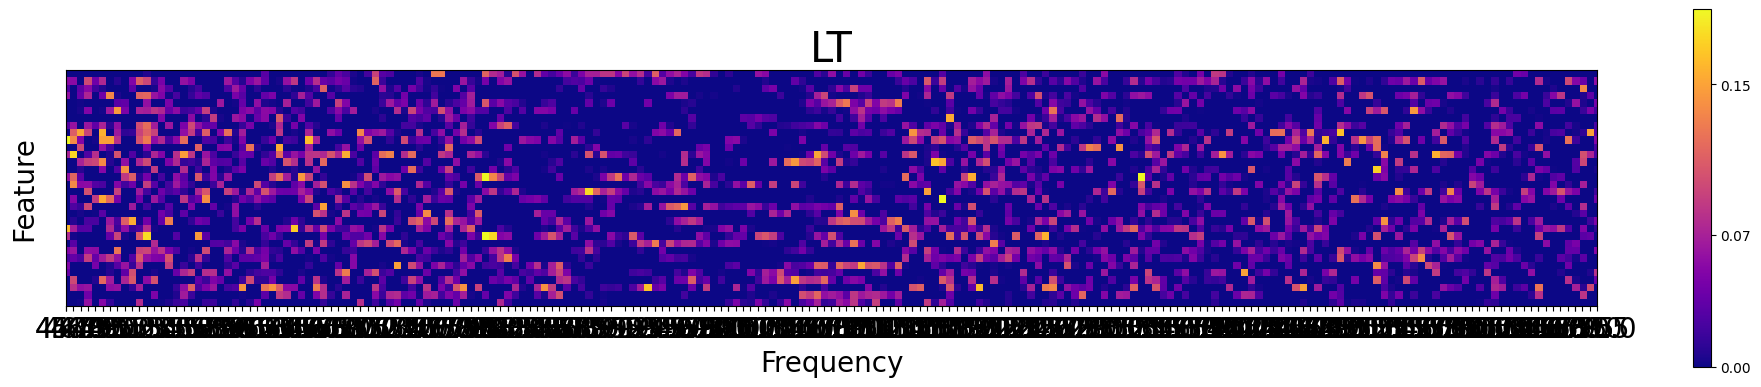

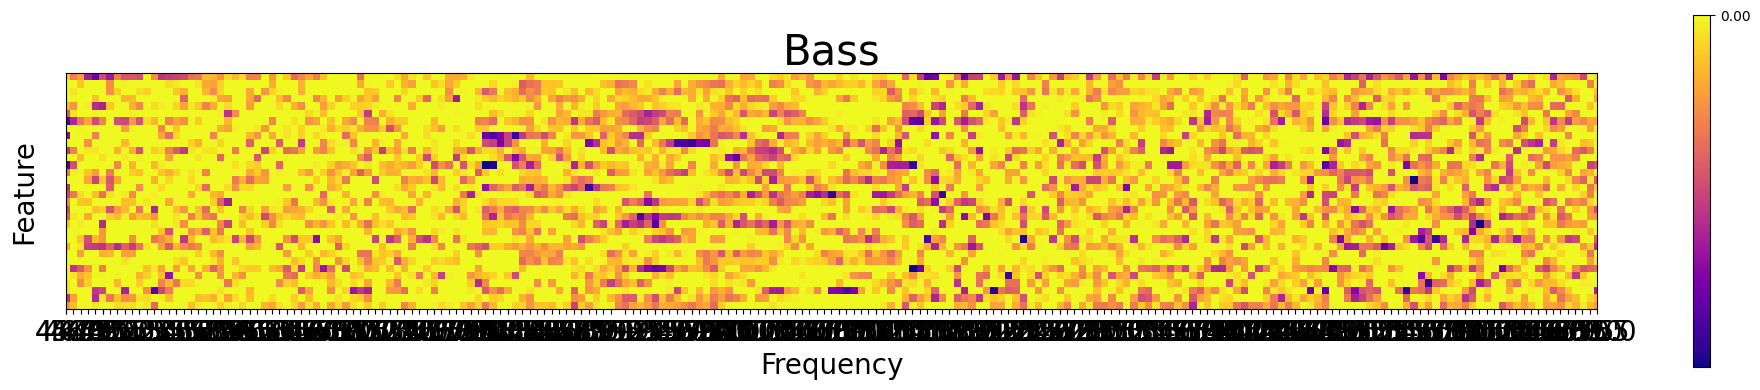

In [20]:
W = model.classifier[0].weight.detach().cpu().numpy()
W = W.reshape((1, 32, -1))
W_fun = W[0]
# For positive weights
W_pos = np.maximum(0, W)  # Retain only positive weights
highest_val_pos = np.percentile(W_pos, 99.9)

# For negative weights
W_neg = np.minimum(0, W)  # Retain only negative weights
highest_val_neg = np.percentile(W_neg, 0.01)  # Use 0.1 percentile for negative values as we want the least negative

W_fun = W[0]
W_fun = np.maximum(0, W_fun)
highest_val = np.percentile(W_fun, 99.9)
fig, ax = plt.subplots(figsize = (20,4))



plt.imshow(W_fun, vmin = lowest_val, vmax = highest_val, cmap =plt.get_cmap('plasma'))

plt.xticks(ticks = a,labels = b, fontsize = 20);
plt.yticks([]);
ax.set_xlim(0,208)
ax.set_xlabel("Frequency", fontsize =20,)

ax.set_ylabel("Feature", fontsize =20,rotation = 90, labelpad=20)
plt.title("LT", fontsize = 30);
plt.colorbar(ticks = [0, 0.07,.15])
plt.tight_layout()

W_fun = W[0]
W_fun = np.minimum(0, W_fun)
lowest_val = np.percentile(W_fun, 0.1)
fig, ax = plt.subplots(figsize = (20,4))
# Negative weights heatmap
plt.imshow(W_fun, vmin = lowest_val, vmax = 0, cmap =plt.get_cmap('plasma'))

plt.xticks(ticks = a,labels = b, fontsize = 20);
plt.yticks([]);
ax.set_xlim(0,208)
ax.set_xlabel("Frequency", fontsize =20,)

ax.set_ylabel("Feature", fontsize =20,rotation = 90, labelpad=20)
plt.title("Bass", fontsize = 30);
plt.colorbar(ticks = [0, 0.07,.15])
plt.tight_layout()

In [19]:
#pickle weights
pkl_dict ={}
for functional_group in range(17):


    W = model.classifier[0].weight.detach().cpu().numpy()
    W = W.reshape((17, 8, -1))
    W_fun = W[functional_group]
    pkl_dict[irindex.columns[8+functional_group]] = W_fun
# save the dictionary
with open(oj(fig_path, 'weights.pkl'), 'wb') as f:
    pickle.dump(pkl_dict, f, pickle.HIGHEST_PROTOCOL)

In [20]:
for functional_group in range(17):
    print("\\begin{{figure*}} \centering \includegraphics[width=.95\linewidth]{{Figures/acts_{0}.pdf}}  \caption{{Dense weights for {0}}} \end{{figure*}}".format(irindex.columns[8+functional_group]))



\begin{figure*} \centering \includegraphics[width=.95\linewidth]{Figures/acts_alkane.pdf}  \caption{Dense weights for alkane} \end{figure*}
\begin{figure*} \centering \includegraphics[width=.95\linewidth]{Figures/acts_methyl.pdf}  \caption{Dense weights for methyl} \end{figure*}
\begin{figure*} \centering \includegraphics[width=.95\linewidth]{Figures/acts_alkene.pdf}  \caption{Dense weights for alkene} \end{figure*}
\begin{figure*} \centering \includegraphics[width=.95\linewidth]{Figures/acts_alkyne.pdf}  \caption{Dense weights for alkyne} \end{figure*}
\begin{figure*} \centering \includegraphics[width=.95\linewidth]{Figures/acts_alcohols.pdf}  \caption{Dense weights for alcohols} \end{figure*}
\begin{figure*} \centering \includegraphics[width=.95\linewidth]{Figures/acts_amines.pdf}  \caption{Dense weights for amines} \end{figure*}
\begin{figure*} \centering \includegraphics[width=.95\linewidth]{Figures/acts_nitriles.pdf}  \caption{Dense weights for nitriles} \end{figure*}
\begin{figur

# Figures


In [22]:
# comparison plot
name_list = [x.capitalize() for x in irindex.columns[8:]]

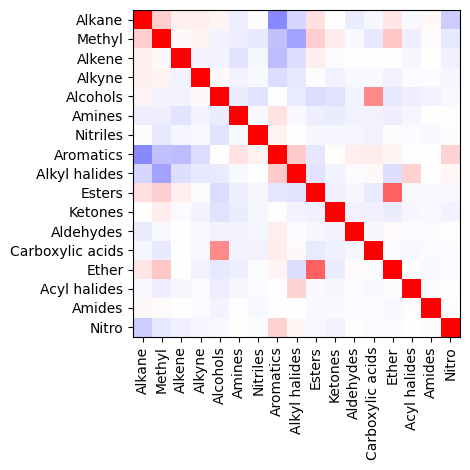

In [23]:

plt.imshow(np.corrcoef (y.T), cmap = plt.get_cmap('bwr'), vmax =1, vmin =-1)
plt.yticks(np.arange(17), name_list);
plt.xticks(np.arange(17), name_list,rotation =90);
# plt.xticks([]);
plt.tight_layout()

plt.savefig(oj(fig_path, "correlation.pdf"),bbox_inches='tight')


In [18]:
results_all.iloc[0]

filename                                                8681648051
exp_name                                                          
batch_size                                                     128
num_epochs                                                    1000
seed                                                             0
num_conv                                                        16
patience                                                         5
train_losses     [0.6180226571241002, 0.5331399640080275, 0.475...
test_acc         [0.65475, 0.7435, 0.803, 0.82475, 0.83925, 0.8...
best_test_acc                                              0.85725
test_auc                                                  0.898979
Name: 0, dtype: object

In [19]:
model_idx

0